# Voter Partisanship Model
The aim of this project was to improve upon the modelling efforts of the Texas Democratic Party and predict an individual's likelihood of supporting the progressive candidate in their respective Texas State House district. This part of the Mon4rch Model focuses solely on partisanship. In conjuction with a voter turnout model, this model was used to simulate election results for the 11 targeted State House Districts. In the 2024 cycle, we opted to use a CatBoost classification model, but this notebook can be used to inform future iterations of TDP modeling.

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
from shapely.geometry import shape
from shapely import wkt
import mapclassify as mc
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import catboost as cb
# import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, auc, roc_curve, RocCurveDisplay, mean_absolute_error, log_loss
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans
from sklearn.utils import parallel_backend
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelBinarizer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LassoCV, SGDRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, StackingClassifier, StackingRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.calibration import CalibrationDisplay
from joblib import Parallel, delayed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import google
from google.cloud import bigquery
import pandas_gbq
import pyarrow
import db_dtypes
import logging
import psutil
import warnings
warnings.filterwarnings(action="ignore")

# Data cleaning//Preprocessing

In [53]:
# client = bigquery.Client(project='demstxsp')
# svs = client.query('SELECT DISTINCT(p.person_id), responses.state_house_district as district, sq.survey_question_text, responses.survey_question_id, (CASE WHEN codes.master_survey_response_name LIKE "1 - Strong Democrat" THEN 1 WHEN codes.master_survey_response_name LIKE "2 - Lean Democrat" THEN 0.75 WHEN codes.master_survey_response_name LIKE "Ticket Splitter - D" THEN 0.67 WHEN codes.master_survey_response_name LIKE "Ticket Splitter - R" THEN 0.33 WHEN codes.master_survey_response_name LIKE "4 - Lean GOP" THEN 0.25 WHEN codes.master_survey_response_name LIKE "5 - Strong GOP" THEN 0 WHEN codes.master_survey_response_name IN ("3rd P/Independent", "3 - Undecided", "Ticket Splitter") THEN 0.5 ELSE null END) AS PartyID, (CASE WHEN codes.master_survey_response_name LIKE "Ticket Splitter" THEN 2 WHEN codes.master_survey_response_name IN ("3rd P/Independent", "3 - Undecided") THEN 2 ELSE 1 END) AS Straight_v_Split_Ticket FROM `demstxsp.vansync_derived.responses_myv` AS responses LEFT JOIN `demstxsp.vansync.master_survey_responses` AS codes ON codes.master_survey_response_id = responses.master_survey_response_id LEFT JOIN `democrats.crosswalks_tx.vanid_to_personid` as p ON responses.myv_van_id = p.myv_van_id LEFT JOIN `demstxsp.vansync.survey_questions` AS sq ON responses.survey_question_id = sq.survey_question_id WHERE master_survey_response_name IS NOT NULL and responses.state_house_district IN ("034", "052", "054", "070", "074", "094", "096", "112", "118", "121", "138") and responses.survey_question_id IN ("596010", "565917") and sq.survey_question_cycle = 2024').to_dataframe()
# sq_hdc_support = client.query('SELECT DISTINCT(dr.person_id),  dr.state_house_district as district,  sq.survey_question_text,  msr.master_survey_response_name, CASE WHEN msr.master_survey_response_name LIKE "1 - Strong Support" THEN 1 WHEN msr.master_survey_response_name LIKE "2 - Lean Support" THEN 0.75    WHEN msr.master_survey_response_name IN ("Other/3rd Party", "3 - Undecided") THEN 0.5 WHEN msr.master_survey_response_name LIKE "4 - Lean GOP" THEN 0.25    WHEN msr.master_survey_response_name LIKE "5 - Strong GOP" THEN 0    ELSE null     END AS hdc_support FROM `demstxsp.vansync.survey_questions` AS sq LEFT JOIN `demstxsp.vansync_derived.responses_myv` AS dr ON dr.survey_question_id = sq.survey_question_id LEFT JOIN `demstxsp.vansync.master_survey_responses` AS msr ON msr.master_survey_response_id = dr.master_survey_response_id WHERE dr.state_house_district IN ("034", "052", "054", "070", "074", "094", "096", "112", "118", "121", "138") AND sq.survey_question_id IN ("599162", "57327", "558037", "582612", "605815", "599005", "571247", "593995", "602018", "604440", "466236", "588258")').to_dataframe() 
# allred_msq = client.query('SELECT DISTINCT(p.person_id), responses.state_house_district as district, responses.survey_question_id, responses.master_survey_question_id, codes.master_survey_response_name as allred_approval FROM `demstxsp.vansync_derived.responses_myv` AS responses LEFT JOIN `demstxsp.vansync.master_survey_responses` AS codes ON codes.master_survey_response_id = responses.master_survey_response_id LEFT JOIN `democrats.crosswalks_tx.vanid_to_personid` as p ON responses.myv_van_id = p.myv_van_id WHERE state_house_district IN ("034", "052", "054", "070", "074", "094", "096", "112", "118", "121", "138") and survey_question_id = "565021"').to_dataframe()
# svs[['person_id', 'district']] = svs[['person_id', 'district']].apply(pd.to_numeric)
# svs = svs.replace({'district': {'034': 34, '052' : 52, '054' : 54, '070': 70, '074': 74, '094' : 94, '096' : 96}})
# svs = svs.drop(columns = ['survey_question_text', 'survey_question_id'])

# sq_hdc_support[['person_id', 'district']] = sq_hdc_support[['person_id', 'district']].apply(pd.to_numeric)
# sq_hdc_support = sq_hdc_support.replace({'district': {'034': 34, '052' : 52, '054' : 54, '070': 70, '074': 74, '094' : 94, '096' : 96}})
# sq_hdc_support = sq_hdc_support.rename(columns = {'hdc_support':'Dem_HD_Approval'})
# sq_hdc_support = sq_hdc_support.drop(columns = ['survey_question_text', 'master_survey_response_name'])

# allred_msq[['person_id', 'district']] = allred_msq[['person_id', 'district']].apply(pd.to_numeric)
# allred_msq = allred_msq.replace({'district': {'034': 34, '052' : 52, '054' : 54, '070': 70, '074': 74, '094' : 94, '096' : 96}})
# allred_msq = allred_msq.replace({'allred_approval' :{'1 - Strong Support': 1, '2 - Lean Support' : 0.75, '3 - Undecided': 0.5, '4 - Lean GOP': 0.25, '5 - Strong GOP' : 0, 'Other/3rd Party': 0}})
# allred_msq = allred_msq.drop(columns = ['survey_question_id', 'master_survey_question_id'])

In [54]:
df = pd.read_csv(r"C:\Users\shali\OneDrive\Documents\TDP\HD MODEL\bq-results-20240927-165054-1727455977250.csv")
df[['person_id', 'district']] = df[['person_id', 'district']].apply(pd.to_numeric)
df = df.replace({'district': {'034': 34, '052' : 52, '054' : 54, '070': 70, '074': 74, '094' : 94, '096' : 96}})
df = df.replace({'allred_approval' :{'1 - Strong Support': 1, '2 - Lean Support' : 0.75, '3 - Undecided': 0.5, '4 - Lean GOP': 0.25, '5 - Strong GOP' : 0, 'Other/3rd Party': 0}})

In [55]:
hd_polling_data = pd.read_csv(r"C:\Users\shali\OneDrive\Documents\TDP\HD MODEL\hdc_model.csv")
hd_polling_data2 = pd.read_csv(r"C:\Users\shali\OneDrive\Documents\TDP\HD MODEL\hd_polling_data2.csv")
allred_msq = pd.read_csv(r"C:\Users\shali\OneDrive\Documents\TDP\HD MODEL\allred_msq.csv")
svs = pd.read_csv(r"C:\Users\shali\OneDrive\Documents\TDP\HD MODEL\svs.csv")

#hd_polling_data = hd_polling_data.merge(svs, how = "left", left_on=['person_id', 'district'], right_on=['person_id', 'district'])
hd_polling_data2 = hd_polling_data2.merge(svs, how = "left", left_on=['person_id', 'district'], right_on=['person_id', 'district'])
hd_polling_data2 = hd_polling_data2.drop(columns = ['PartyID_y'])
hd_polling_data2 = hd_polling_data2.rename(columns= {'PartyID_x' :'PartyID'})
df_college = df[['person_id', 'district', 'college_degree']]
hd_polling_data2 = hd_polling_data2.merge(df_college, how = "left", left_on=['person_id', 'district'], right_on=['person_id', 'district'])

hd_polling_data = hd_polling_data.replace({'college_degree': {1: 1, 2: 0}})
hd_polling_data = hd_polling_data.rename(columns= {'college_degree' : 'college_degree_poll'})

hd_polling_data = hd_polling_data.replace({'hdc_support': {1: 0, 2: 1, 3: 0.5}})
hd_polling_data = hd_polling_data.replace({'hdc_support_2': {1: 0, 2: 1, 3: 0.5}})
hd_polling_data = hd_polling_data.replace({'hdc_support_3': {1: 0, 2: 1, 3: 0.5}})

hd_polling_data.loc[hd_polling_data['PartyID'] == 1, 'hdc_support'] = hd_polling_data.loc[hd_polling_data['PartyID'] == 1, 'hdc_support'].fillna(1)
hd_polling_data.loc[hd_polling_data['PartyID'] == 2, 'hdc_support'] = hd_polling_data.loc[hd_polling_data['PartyID'] == 2, 'hdc_support'].fillna(0)
hd_polling_data.loc[hd_polling_data['PartyID'] == 1, 'hdc_support_2'] = hd_polling_data.loc[hd_polling_data['PartyID'] == 1, 'hdc_support_2'].fillna(1)
hd_polling_data.loc[hd_polling_data['PartyID'] == 2, 'hdc_support_2'] = hd_polling_data.loc[hd_polling_data['PartyID'] == 2, 'hdc_support_2'].fillna(0)
hd_polling_data.loc[hd_polling_data['PartyID'] == 1, 'hdc_support_3'] = hd_polling_data.loc[hd_polling_data['PartyID'] == 1, 'hdc_support_3'].fillna(1)
hd_polling_data.loc[hd_polling_data['PartyID'] == 2, 'hdc_support_3'] = hd_polling_data.loc[hd_polling_data['PartyID'] == 2, 'hdc_support_3'].fillna(0)

hd_polling_data = hd_polling_data.replace({'Dem_HD_Approval': {1: 1, 2: 0.75, 3: 0.25, 4: 0, 5:0.5}})
hd_polling_data = hd_polling_data.replace({'Rep_HD_Approval': {1: 0, 2: 0.25, 3: 0.75, 4: 1, 5:0.5}})
hd_polling_data = hd_polling_data.replace({'trump_approval': {1: 0, 2: 0.25, 3: 0.75, 4: 1, 5:0.5}})
hd_polling_data = hd_polling_data.replace({'cruz_approval': {1: 0, 2: 0.25, 3: 0.75, 4: 1, 5:0.5}})
hd_polling_data = hd_polling_data.replace({'biden_approval': {1: 1, 2: 0.75, 3: 0.25, 4: 0, 5:0.5}})
hd_polling_data = hd_polling_data.replace({'harris_approval': {1: 1, 2: 0.75, 3: 0.25, 4: 0, 5:0.5}})
hd_polling_data = hd_polling_data.replace({'allred_approval': {1: 1, 2: 0.75, 3: 0.25, 4: 0, 5:0.5}})

hd_polling_data2 = hd_polling_data2.replace({'Dem_HD_Approval': {1: 1, 2: 0.75, 3: 0.25, 4: 0, 5:0.5}})
hd_polling_data2 = hd_polling_data2.replace({'Rep_HD_Approval': {1: 0, 2: 0.25, 3: 0.75, 4: 1, 5:0.5}})
hd_polling_data2 = hd_polling_data2.replace({'trump_approval': {1: 0, 2: 0.25, 3: 0.75, 4: 1, 5:0.5}})
hd_polling_data2 = hd_polling_data2.replace({'cruz_approval': {1: 0, 2: 0.25, 3: 0.75, 4: 1, 5:0.5}})
hd_polling_data2 = hd_polling_data2.replace({'harris_approval': {1: 1, 2: 0.75, 3: 0.25, 4: 0, 5:0.5}})
hd_polling_data2 = hd_polling_data2.replace({'allred_approval': {1: 1, 2: 0.75, 3: 0.25, 4: 0, 5:0.5}})

hd_polling_data['hd_persuasion'] = hd_polling_data[['hdc_support', 'hdc_support_2', 'hdc_support_3']].mean(axis=1)
hd_polling_data['hd_favorability'] = hd_polling_data[['Dem_HD_Approval', 'Rep_HD_Approval']].mean(axis=1)
hd_polling_data = hd_polling_data.drop(columns = ['hdc_support_2', 'change_w_info', 'hdc_support_3', 'change_w_info_2', 'hd_persuasion', 'hd_favorability'])
hd_polling_data = hd_polling_data.rename(columns= {'college_degree_poll' : 'college_degree'})

In [56]:
train = pd.concat([hd_polling_data, hd_polling_data2])
train['Straight_v_Split_Ticket'] = train['Straight_v_Split_Ticket'].replace({'1D': 1, '1R': 1})
train = train.drop(columns = ['Phone'])
train = train.replace({pd.NA: np.nan})

In [57]:
df_joining = df.drop(columns = ['age_range', 'gender', 'age_combined', 'college_degree', 'hdc_support', 'allred_approval', 'Straight_v_Split_Ticket', 'party_id'])
train_df_merge = pd.merge(train, df_joining, how= 'left', on= ['person_id', 'district', 'Support_Score', 'Turnout_Score'] )
train_df_merge = train_df_merge.drop_duplicates()
train_df_merge = train_df_merge.replace({pd.NA: np.nan})

train_df_merge.loc[train_df_merge['hispanic/latino'] == 1, 'eth_h'] = train_df_merge.loc[train_df_merge['hispanic/latino'] == 1, 'eth_h'].fillna(1)
train_df_merge.loc[train_df_merge['hispanic/latino'] == 2, 'eth_h'] = train_df_merge.loc[train_df_merge['hispanic/latino'] == 2, 'eth_h'].fillna(0)
train_df_merge = train_df_merge.drop(columns = ['hispanic/latino'])

## Impute Training Dataset 

In [58]:
knn_imputer = KNNImputer(n_neighbors=5)
train_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(train_df_merge), columns=train_df_merge.columns)
train = train_knn_imputed.drop(['Turnout_Score', 'Straight_v_Split_Ticket', 'PartyID', 'Dem_HD_Approval', 'Rep_HD_Approval', 'trump_approval', 'cruz_approval', 'harris_approval', 'allred_approval', 'religion_other_christian', 'dem_primary_votes', 'choice_support', 'tsmart_2016_donor_likelihood', 'civis_2018_ballot_completion', 'dnc_2016_rolloff_risk_rank', 'dnc_2016_downballot_vote', 'dnc_2016_downballot_defection_rank', 'rep_primary_votes', 'dnc_2020_dem_party_support_v2', 'dnc_2022_dem_party_support_v2', 'civis_2018_ballot_dropoff', 'religion_catholic', 'eth_n', 'eth_w'], axis=1)

## Feature Selection

In [59]:
train_knn_imputed = add_constant(train_knn_imputed)
vif_initial = pd.DataFrame()
vif_initial["feature"] = train_knn_imputed.columns

# calculating VIF for each feature
vif_initial["VIF"] = [variance_inflation_factor(train_knn_imputed.values, i)
                          for i in range(len(train_knn_imputed.columns))]
vif_initial = vif_initial.sort_values(by = 'VIF', ascending = False)
vif_initial = vif_initial[vif_initial['VIF'] > 10]
vif_initial

,feature,VIF
26,civis_2018_ballot_dropoff,9.007199e+15
27,civis_2018_ballot_completion,5.629500e+14
45,religion_evangelical_protestant,1.005613e+07
46,religion_catholic,6.076837e+06
54,religion_not_religious,5.381792e+06
49,religion_hindu,2.769461e+06
50,religion_mainline_protestant,2.645877e+06
48,religion_jewish,8.198892e+05
52,religion_other_christian,5.726359e+05
53,religion_buddhist,4.441316e+05


In [60]:
train_knn_imputed_2 = train_knn_imputed.drop(['civis_2018_ballot_completion', 'religion_catholic'], axis=1)
vif_initial_2 = pd.DataFrame()
vif_initial_2["feature"] = train_knn_imputed_2.columns
vif_initial_2["VIF"] = [variance_inflation_factor(train_knn_imputed_2.values, i)
                          for i in range(len(train_knn_imputed_2.columns))]
vif_initial_2 = vif_initial_2.sort_values(by = 'VIF', ascending = False)
vif_initial_2 = vif_initial_2[vif_initial_2['VIF'] > 10]
vif_initial_2

,feature,VIF
0,const,2624.441090
67,dem_primary_votes,56.731960
17,dnc_2020_dem_party_support_v2,55.148674
68,rep_primary_votes,36.994321
26,civis_2018_ballot_dropoff,33.172719
18,dnc_2022_dem_party_support_v2,32.920029
57,p2020_d,30.122964
27,deck_2022_state_house_support,23.242550
1,person_id,22.912754
23,dnc_2018_downballot_vote,21.727588


In [61]:
train_knn_imputed_3 = train_knn_imputed_2.drop(['Straight_v_Split_Ticket', 'trump_approval', 'cruz_approval', 'harris_approval', 'allred_approval', 'dem_primary_votes', 'rep_primary_votes', 'dnc_2020_dem_party_support_v2', 'dnc_2022_dem_party_support_v2', 'eth_a', 'civis_2018_ballot_dropoff', 'choice_support', 'religion_not_religious', 'religion_mainline_protestant', 'dnc_2018_downballot_vote', 'g2014', 'dnc_2018_downballot_defection_rank', 'tsmart_2016_donor_likelihood'], axis=1)
vif_initial_3 = pd.DataFrame()
vif_initial_3["feature"] = train_knn_imputed_3.columns
vif_initial_3["VIF"] = [variance_inflation_factor(train_knn_imputed_3.values, i)
                          for i in range(len(train_knn_imputed_3.columns))]
vif_initial_3 = vif_initial_3.sort_values(by = 'VIF', ascending = False)
vif_initial_3 = vif_initial_3[vif_initial_3['VIF'] > 5]
vif_initial_3

,feature,VIF
0,const,1078.156470
15,deck_2022_state_house_support,15.285932
48,g2012,9.974386
45,g2016,9.092563
1,person_id,8.477506
42,p2020_d,7.544413
47,p2016_r,7.322956
44,g2018,6.422657
16,dnc_2022_malaise,6.168964
14,dnc_2016_downballot_defection_rank,5.639697


'Straight_v_Split_Ticket' was removed, despite being a prominent feature from the polls returned to us by Frederick Polls in 2024 General Cycle, as there were only 12,910 responses to this question in BigQuery out of the 1,390,914 individuals in our test data set for these targeted districts. I opted to keep 'deck_2022_state_house_support' as the models we will be using are not as sensitive to multicollinearity, and this feature was expected to improve the predictive performance of the model without significantly compromising model accuracy.  

## Impute Missing Data in Test Dataset

In [62]:
df = df[~df['person_id'].isin(train_df_merge['person_id'])] # remove poll sample
# sample = df.drop(['party_id', 'age_combined', 'civis_2018_ballot_completion', 'religion_catholic', 'dnc_2020_dem_party_support_v2', 'dnc_2022_dem_party_support_v2', 'eth_a', 'civis_2018_ballot_dropoff', 'choice_support', 'religion_not_religious', 'religion_mainline_protestant', 'dnc_2018_downballot_vote', 'g2014', 'dnc_2018_downballot_defection_rank', 'tsmart_2016_donor_likelihood'], axis=1)
sample = df.drop(['Straight_v_Split_Ticket', 'party_id', 'Turnout_Score', 'age_combined', 'allred_approval', 'religion_other_christian', 'dem_primary_votes', 'choice_support', 'tsmart_2016_donor_likelihood', 'civis_2018_ballot_completion', 'dnc_2016_rolloff_risk_rank', 'dnc_2016_downballot_vote', 'dnc_2016_downballot_defection_rank', 'rep_primary_votes', 'dnc_2020_dem_party_support_v2', 'dnc_2022_dem_party_support_v2', 'civis_2018_ballot_dropoff', 'religion_catholic', 'eth_n', 'eth_w'], axis=1)
X_sample = sample.drop(['hdc_support'], axis=1)
y_sample = np.array(sample['hdc_support'].astype('float64'))

In [63]:
X_sample = X_sample[['person_id', 'district', 'Support_Score', 'gender', 'age_range', 'college_degree', 'dnc_2018_downballot_vote', 'dnc_2018_downballot_defection_rank', 'deck_2022_state_house_support', 'dnc_2022_malaise', 'healthcare_costs_persuasion_22', 'healthcare_costs_persuasion_24', 'trump_check_persuasion_20', 'trump_check_persuasion_22', 'trump_check_persuasion_24', 'gun_control_persuasion_20', 'gun_control_persuasion_22', 'gun_control_persuasion_24', 'abortion_persuasion_22', 'abortion_persuasion_24', 'eth_b', 'eth_h', 'eth_a', 'religion_evangelical_protestant', 'religion_muslim', 'religion_jewish', 'religion_hindu', 'religion_mainline_protestant', 'religion_latter_day_saint', 'religion_buddhist', 'religion_not_religious', 'p2024_d', 'p2024_r', 'g2022', 'g2020', 'p2020_d', 'p2020_r', 'g2018', 'g2016', 'p2016_d', 'p2016_r', 'g2014', 'g2012', 'p2012_d', 'p2012_r']]

In [64]:
logging.basicConfig(level=logging.INFO) 

# Memory logging function
def log_memory():
    mem = psutil.virtual_memory()
    logging.info(f"Memory Usage: {mem.used / 1e9:.2f} GB / {mem.total / 1e9:.2f} GB")

In [65]:
kmeans = KMeans(n_clusters=14, random_state=42)
knn_imputer = KNNImputer(n_neighbors=3)
# Impute missing values before clustering
simple_imputer = SimpleImputer(strategy='mean')
sample_imputed_for_clustering = pd.DataFrame(simple_imputer.fit_transform(X_sample), columns=X_sample.columns)

# cluster X_sample using simply imputed dataset
sample_imputed_for_clustering['cluster'] = kmeans.fit_predict(sample_imputed_for_clustering)
sample_imputed_for_clustering = sample_imputed_for_clustering.reset_index(drop=True)
X_sample = X_sample.reset_index(drop=True)

In [66]:
# Function to split data into chunks
def chunk_data(X_sample, n_chunks):
    return np.array_split(X_sample, n_chunks)

# chunks bigquery data 
def impute_chunk(chunk, batch_size=50_000):
    logging.info(f"Processing chunk of shape {chunk.shape}")
    log_memory()  # Log before processing
    imputed_batches = [knn_imputer.fit_transform(chunk[i : i + batch_size]) 
                       for i in range(0, len(chunk), batch_size)]
    log_memory()  # Log after processing
    return np.vstack(imputed_batches)

In [67]:
# sets up parallelization for imputation
def parallel_impute(data, n_chunks=14, n_jobs=2):
    data_chunks = chunk_data(data, n_chunks)
    try:
        with parallel_backend('loky', n_jobs=n_jobs):  # Use 'loky' to manage memory better
            imputed_chunks = Parallel()(delayed(impute_chunk)(chunk) for chunk in data_chunks)
    except Exception as e:
        logging.error(f"Error during parallel processing: {e}")
        raise
    return np.vstack(imputed_chunks)

In [68]:
# impute missing values within each cluster
def impute_within_clusters(data, n_chunks=14, n_jobs=2):
    imputed_data = []

    for cluster_id in data['cluster'].unique():
        cluster_data = data[data['cluster'] == cluster_id]
        cluster_features = cluster_data.drop(columns=['cluster'])
        imputed_cluster = cluster_data.copy()
        imputed_cluster[cluster_features.columns] = parallel_impute(cluster_features, n_chunks=n_chunks, n_jobs=n_jobs)
        imputed_data.append(imputed_cluster)
    
    return pd.concat(imputed_data, axis=0)

In [69]:
# Function to get imputed values for a specific cluster
def get_imputed_values_for_cluster(imputed_data, original_data, cluster_labels, cluster_id):
    mask = (cluster_labels == cluster_id)  # Boolean mask for the cluster
    imputed_cluster_data = imputed_data.loc[mask]
    original_cluster_data = original_data.loc[mask]
    
    return imputed_cluster_data.where(original_cluster_data.isna())

In [70]:
# Apply imputation within clusters
sample_imputed = impute_within_clusters(sample_imputed_for_clustering, n_chunks=2, n_jobs=1).reset_index(drop=True)

INFO:root:Processing chunk of shape (48296, 45)
INFO:root:Memory Usage: 14.02 GB / 17.01 GB
INFO:root:Memory Usage: 14.06 GB / 17.01 GB
INFO:root:Processing chunk of shape (48295, 45)
INFO:root:Memory Usage: 14.06 GB / 17.01 GB
INFO:root:Memory Usage: 14.08 GB / 17.01 GB
INFO:root:Processing chunk of shape (89998, 45)
INFO:root:Memory Usage: 14.20 GB / 17.01 GB
INFO:root:Memory Usage: 14.23 GB / 17.01 GB
INFO:root:Processing chunk of shape (89998, 45)
INFO:root:Memory Usage: 14.22 GB / 17.01 GB
INFO:root:Memory Usage: 14.26 GB / 17.01 GB
INFO:root:Processing chunk of shape (19154, 45)
INFO:root:Memory Usage: 14.06 GB / 17.01 GB
INFO:root:Memory Usage: 14.06 GB / 17.01 GB
INFO:root:Processing chunk of shape (19154, 45)
INFO:root:Memory Usage: 14.06 GB / 17.01 GB
INFO:root:Memory Usage: 14.07 GB / 17.01 GB
INFO:root:Processing chunk of shape (127908, 45)
INFO:root:Memory Usage: 14.38 GB / 17.01 GB
INFO:root:Memory Usage: 14.43 GB / 17.01 GB
INFO:root:Processing chunk of shape (127908, 45

In [71]:
# Vectorized approach to extract imputed values for all clusters
cluster_labels = sample_imputed_for_clustering['cluster']
cluster_imputed_values = {
    cluster_id: get_imputed_values_for_cluster(sample_imputed, X_sample, cluster_labels, cluster_id)
    for cluster_id in sorted(cluster_labels.unique())  # Sort for consistency
    }

In [72]:
# Combine all imputed values for each cluster into a single dataset
combined_imputed_values = pd.concat(cluster_imputed_values.values(), axis=0)
combined_imputed_values = combined_imputed_values.drop(columns=['cluster'])
X_sample_imputed = X_sample.combine_first(combined_imputed_values)

## Split Data into Train and Test Sets

In [73]:
#train_df_merge['person_id'] = train_df_merge['person_id'].astype('float64')
# train test split
X = train.drop(['hdc_support'], axis=1)
y = train['hdc_support']
y = y.values.astype(float)
y = y.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
X = add_constant(X)
vif_train = pd.DataFrame()
vif_train["feature"] = X.columns

# calculating VIF for each feature
vif_train["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_train = vif_train.sort_values(by = 'VIF', ascending = False)
vif_train

,feature,VIF
0,const,1097.983742
9,deck_2022_state_house_support,14.822221
23,eth_a,12.421411
31,religion_not_religious,10.534336
42,g2014,10.352646
43,g2012,10.333004
1,person_id,10.207422
39,g2016,9.427529
41,p2016_r,9.368675
27,religion_hindu,8.793280


In hindsight, I would remove features, such as 'eth_a' and 'g2014', as well.

# Baseline (DNC)

In [75]:
label_binarizer = LabelBinarizer()
y_train_binarized = label_binarizer.fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform([1.0])
class_of_interest = 1.0
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

y_pred_probs = X_test['Support_Score']
y_pred = [1 if prob > 0.7 else 0.5 if 0.4 <= prob <= 0.7 else 0 for prob in y_pred_probs]
y_pred = np.array(y_pred)
y_pred = y_pred.reshape(-1, 1)
y_pred = encoder.fit_transform(y_pred)
y_pred_onehot = label_binarizer.transform(y_pred)
print(f"y_pred_binarized shape: {y_pred_onehot.shape}")

y_pred_binarized shape: (844, 3)


In [76]:
n_classes = len(np.unique(y_onehot_test))
y = pd.DataFrame(y)
target_names = y.columns

#  store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

DNC Metrics:
ROC AUC Score: 0.7101
MAE: 0.1864
MSE: 0.1864
R-squared (R2 Score): -0.1482


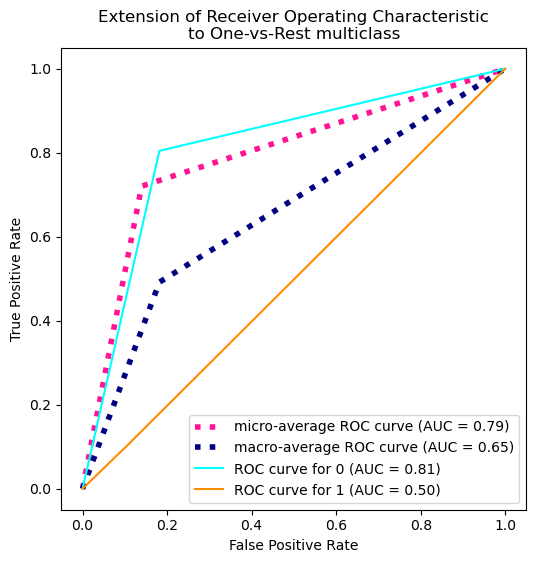

In [77]:
print('DNC Metrics:')
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_onehot):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_onehot):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_onehot):.4f}")
print(f"R-squared (R2 Score): {r2_score(y_test, y_pred_onehot):.4f}")

#
fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = ["aqua", "darkorange", "cornflowerblue"]
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_onehot[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        # plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

In [78]:
kde_df = sample[['person_id', 'Support_Score']] #support score here refers to the DNC support score, we will be adding to predictions for each model below to this dataframe

# Ensemble Modeling

## Lasso

In [79]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [80]:
alphas = [0.01, 0.1, 1, 10, 100]

# Create Ridge with cross-validation
ridge_cv = GridSearchCV(Ridge(), param_grid={'alpha': alphas}, cv=100)
ridge_cv.fit(X_train_scaled, y_train)

# Best alpha
print("Best alpha:", ridge_cv.best_params_)
ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train)
y_train_ridge = ridge.predict(X_train)
y_test_ridge = ridge.predict(X_test)

print("R2 (train): " + str(r2_score(y_train, y_train_ridge)))
print("R2 (test): " + str(r2_score(y_test, y_test_ridge))+ "\n")

print("MSE (train): " + str(mean_squared_error(y_train, y_train_ridge)))
print("MSE (test): " + str(mean_squared_error(y_test, y_test_ridge)))

Best alpha: {'alpha': 100}
R2 (train): 0.3215512208941322
R2 (test): 0.3108998467387317

MSE (train): 0.11872277012107117
MSE (test): 0.12153881160877104


In [81]:
alphas = [0.01, 0.1, 1, 10, 100]

lasso = Lasso()
lasso_cv = GridSearchCV(lasso, param_grid={'alpha': alphas}, cv=100)
lasso_cv.fit(X_train, y_train)
print(f"Best alpha: ", lasso_cv.best_params_['alpha'])

lasso_best = lasso_cv.best_estimator_

# Display non-zero coefficients
#coefficients = pd.Series(lasso_best.coef_, index=X_train.columns)
#non_zero_coefficients = coefficients[coefficients != 0]
#print("Non-zero coefficients:\n", non_zero_coefficients)

# Evaluate performance on the test set
y_test_pred_lasso = lasso_best.predict(X_test)

# print('DNC Metrics:')
#print(f"ROC AUC Score: {roc_auc_score(y_test_pred_lasso, y_pred_onehot):.4f}")
#print(f"MEA: {mean_absolute_error(y_test_pred_lasso, X_test['Support_Score']):.4f}")
#print(f"MSE: {mean_squared_error(y_test_pred_lasso, X_test['Support_Score']):.4f}")
#print(f"R-squared (R2 Score): {r2_score(y_test_pred_lasso, X_test['Support_Score']):.4f}")

# samp = sample.dropna()
# kde = samp[['person_id', 'Support_Score']]
# X_samp = X_sample.dropna()
# y_pred_best = lasso_best.predict(X_samp)
# kde['lasso'] = y_pred_best


Best alpha:  0.01


## XGBoost

In [82]:
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',        # Logarithmic loss as evaluation metric
    'learning_rate': 0.001,           # Lower learning rate with higher rounds
    'max_depth': 4,                  # Max depth of trees, prevents overfitting
    'min_child_weight': 14,           # Minimum sum of instance weight (hessian) needed in a child
    'gamma': 0.1,                    # Regularization parameter for pruning
    'subsample': 0.8,                # Percentage of training data used per tree
    'colsample_bytree': 0.8,         # Percentage of features used per tree
    'lambda': 0.01,                     # L2 regularization term
    'alpha': 0.01,                      # L1 regularization term
    'n_estimators': 10000,            # Number of boosting rounds
    'seed': 42,                       # Seed for reproducibility
}

In [ ]:
xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train, y_train)

y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (Democrat)

print('Mon4rch Metrics: ')
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
#print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred_proba):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_proba):.4f}")
#print(f"R-squared (R2 Score): {r2_score(y_test, y_pred_proba):.4f}")

# Assuming y_pred is the predicted class (0 or 1), you might need to threshold your predicted probabilities
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_probs]

# Calculate precision, recall, and F1 score
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

# Calculate Log Loss (requires probabilities)
print(f"Log Loss: {log_loss(y_test, y_pred_probs):.4f}")

In [ ]:
y_pred_proba = xgb_model.predict_proba(sample)[:, 1]
kde_df['xg'] = y_pred_proba

## Neural Net

In [ ]:
X = X.values
y = y.values
X = X.astype(np.float64)
y = y.astype(np.float64)

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()
tensor_data = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(tensor_data, batch_size=64, shuffle=True)

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
         super(NeuralNet, self).__init__()
         self.fc1 = nn.Linear(input_size, hidden_size1)
         self.relu1 = nn.ReLU()
         self.dropout1 = nn.Dropout(p=0.2)
         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
         self.relu2 = nn.ReLU()
         self.dropout2 = nn.Dropout(p=0.2)
         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
         self.relu3 = nn.ReLU()
         self.fc4 = nn.Linear(hidden_size3, output_size)
         self.softmax = nn.LogSoftmax()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.softmax(x)

        return x

In [ ]:
model = NeuralNet(input_size = 24, hidden_size1= 512, hidden_size2=256, hidden_size3=64, output_size=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
num_epochs = 300
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0) 
    
    epoch_loss = running_loss / len(dataloader)
    losses.append(epoch_loss)

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

#plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
model.eval()
with torch.no_grad(): 
    predictions = model(X_tensor)

## CatBoost Classifier

In [ ]:
# hyper parameters
cat_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'learning_rate': 0.001,
    'depth': 4,                  # max_depth in trees
    'l2_leaf_reg': 0.01,         # L2 regularization term
    'random_seed': 42,
    'iterations': 10000,
    'subsample': 0.8,            # Percentage of data to use per tree
    'colsample_bylevel': 0.8,
    'min_data_in_leaf': 1,      # min_child_weight
    'random_strength': 0.1,      # gamma
    'border_count': 128,
    'logging_level': 'Silent'
}

In [ ]:
cat_model = cb.CatBoostClassifier(**cat_params)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Predict probabilities
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# metrics
print('Mon4rch Metrics: \n')
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_cat):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_proba_cat):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_proba_cat):.4f}\n")

# scoring
predict_proba_sample = cat_model.predict_proba(sample)[:, 1]
sample['mon4rch_partisanship'] = predict_proba_sample
sample = sample[['person_id', 'mon4rch_partisanship']]
# append scores given to training set ?

## HistGradientBoosting Classifier

In [84]:
hgb_params = {
    'loss_function': 'log_loss',
    'learning_rate': 0.001,
    'depth': 4,                  # max_depth in trees
    'l2_regularization': 0.01,         # L2 regularization term
    'random_seed': 42,
    'iterations': 10000,
    'subsample': 0.8,            # Percentage of data to use per tree
    'colsample_bylevel': 0.8,
    'min_data_in_leaf': 1,      # min_child_weight
    'random_strength': 0.1,      # gamma
    'border_count': 128,
    'logging_level': 'Silent'
}

In [85]:
hgb = HistGradientBoostingClassifier(hgb_params)

# Model Performance (Metrics)

In [86]:
cat_preds = pd.read_csv(r"C:\Users\shali\OneDrive\Documents\TDP\HD MODEL\kde_9_27_1.csv")

## Correlation between Predicted Outputs and DNC support 

### KDE Plots (distributions excluding train_test set)

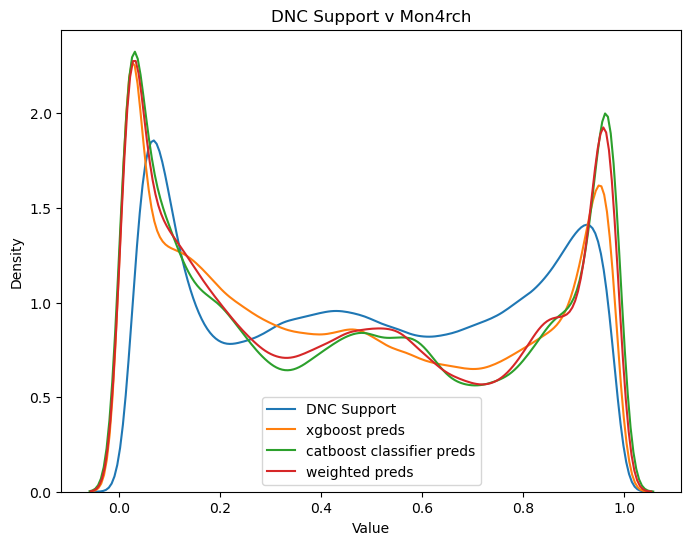

In [ ]:
plt.figure(figsize=(8, 6))

sns.kdeplot(cat_preds['support'], label='DNC Support' )
sns.kdeplot(cat_preds['xg'], label='xgboost preds')
sns.kdeplot(cat_preds['cat'], label='catboost classifier preds')
sns.kdeplot(cat_preds['weighted'], label='weighted preds')
#sns.kdeplot(cat_preds['stack'], label='stackeing classifier preds')

plt.title('DNC Support v Mon4rch')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
cat_kendall_corr = cat_preds['support'].corr(cat_preds['cat'], method='kendall')
print(f"Kendall's Correlation Coefficient (CatBoost Classifier): {cat_kendall_corr}")
weighted_kendall_corr = cat_preds['support'].corr(cat_preds['weighted'], method='kendall')
print(f"Kendall's Correlation Coefficient (weighted): {weighted_kendall_corr}")
stack_kendall_corr = cat_preds['support'].corr(cat_preds['stack'], method='kendall')
print(f"Kendall's Correlation Coefficient (stacking regressor): {stack_kendall_corr}")

Kendall's Correlation Coefficient (CatBoost Classifier): 0.8467027757001173
Kendall's Correlation Coefficient (weighted): 0.8562992320466544
Kendall's Correlation Coefficient (stacking regressor): 0.8377933575392078


### ROC AUC Curve (training set)

In [ ]:
# Compute ROC curve and ROC area for support
fpr_support, tpr_support, _ = roc_curve(y_test, support_probs)
roc_auc_support = auc(fpr_support, tpr_support)

# Compute ROC curve and ROC area for xg
fpr_xg, tpr_xg, _ = roc_curve(y_test, xg_probs)
roc_auc_xg = auc(fpr_xg, tpr_xg)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_support, tpr_support, color='blue', label=f'DNC (AUC = {roc_auc_support:.2f})')
plt.plot(fpr_xg, tpr_xg, color='orange', label=f'Mon4rch (AUC = {roc_auc_xg:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Calibration Curve (training set)

In [ ]:
disp = CalibrationDisplay.from_predictions(y_test, y_pred_best)
plt.show()

support_fraction, support_mean_prob = calibration_curve(y_test, support_probs, n_bins=10)
xg_fraction, xg_mean_prob = calibration_curve(y_test, xg_probs, n_bins=10)

# Plotting the calibration curve
plt.figure(figsize=(10, 6))
plt.plot(support_mean_prob, support_fraction, marker='o', label='DNC')
plt.plot(xg_mean_prob, xg_fraction, marker='o', label='Mon4rch')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')  # Perfectly calibrated line
plt.title('Calibration Curve')
plt.xlabel('Score')
plt.ylabel('Fraction of Positives')
plt.legend(loc='best')
plt.grid()
plt.show()

# Analysis (Post-Election Results)

In [132]:
model_comparisons = pd.read_csv("model_comparisons_target_hd_2024_MOST_RECENT.csv")

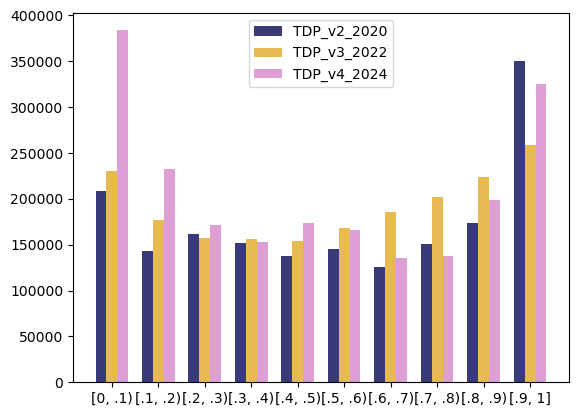

In [134]:
v4_incl_prior_hist = pd.read_csv(r"C:\Users\shali\OneDrive\Documents\TDP\Post-Election Analysis\mon4rch support analysis\v4_incl_prior_hist.csv")

v4_2024 = v4_incl_prior_hist['tdp_24_support_v4']
v3_2022 = v4_incl_prior_hist['tdp_22_support_v3']
v2_2020 = v4_incl_prior_hist['tdp_20_support_v2']

cmap = plt.get_cmap('tab20b', 3)
plt.hist([ v2_2020, v3_2022, v4_2024], bins = 10, label=['TDP_v2_2020', 'TDP_v3_2022', 'TDP_v4_2024'], color=[cmap(i) for i in range(3)], align= 'left', rwidth= 0.7)
plt.xticks(np.arange(0, 1, 0.1), labels= ['[0, .1)', '[.1, .2)', '[.2, .3)', '[.3, .4)', '[.4, .5)', '[.5, .6)', '[.6, .7)', '[.7, .8)', '[.8, .9)', '[.9, 1]'])
plt.legend(loc='upper center')

## Mapping Differences in Model Performance

In [123]:
# Load 2020 and 2022 Precinct Level Results 
v2_results = pd.read_csv(r"C:\Users\shali\OneDrive\Documents\TDP\Post-Election Analysis\mon4rch support analysis\2020 HD D votes (model estimates v actual).csv")
v3_results = pd.read_csv(r"C:\Users\shali\OneDrive\Documents\TDP\Post-Election Analysis\mon4rch support analysis\2022 HD D votes (model estimates v actual).csv")
v2_results['pct_error_tdp'] = (v2_results['tdp_20_est_D_votes'] - v2_results['act_20_D_votes'])/(v2_results['act_20_D_votes'])*100
v2_results['pct_error_dnc'] = (v2_results['dnc_20_est_D_votes'] - v2_results['act_20_D_votes'])/(v2_results['act_20_D_votes'])*100

v3_results['pct_error_tdp']  = (v3_results['tdp_22_est_D_votes'] - v3_results['act_22_D_votes'])/(v3_results['act_22_D_votes'])*100
v3_results['pct_error_dnc']  = (v3_results['dnc_22_est_D_votes'] - v3_results['act_22_D_votes'])/(v3_results['act_22_D_votes'])*100 
v2_results = v2_results.rename(columns={'HD_2020': 'HD', 'precinct_2020': 'precinct'})
v3_results = v3_results.rename(columns={'HD_2022': 'HD', 'precinct_2022': 'precinct'})

v2_v3_diff = pd.merge(v2_results, v3_results, how = 'left', on = ['HD', 'precinct'],  suffixes=('_20', '_22'))

# Load Precinct Shapefiles for HDs
hd_precincts = pd.read_json( r"C:\Users\shali\OneDrive\Documents\TDP\Post-Election Analysis\mon4rch support analysis\hd precincts.json" )
hd_precincts_2 = pd.read_json(r"C:\Users\shali\OneDrive\Documents\TDP\Post-Election Analysis\mon4rch support analysis\hd precincts 2.json" )

hd_precincts = pd.concat([hd_precincts, hd_precincts_2])
hd_precincts['geography'] = hd_precincts['geography'].apply(wkt.loads)
hd_precincts = hd_precincts.dropna()
hd_precincts = hd_precincts.rename(columns={'state_house_district': 'HD', 'van_precinct_id': 'precinct'})
hd_precincts = pd.merge(v2_v3_diff, hd_precincts, how = 'left', on = ['HD', 'precinct'])

<AxesSubplot:title={'center':'Texas Precincts with State House Districts Overlay'}, xlabel='Longitude', ylabel='Latitude'>

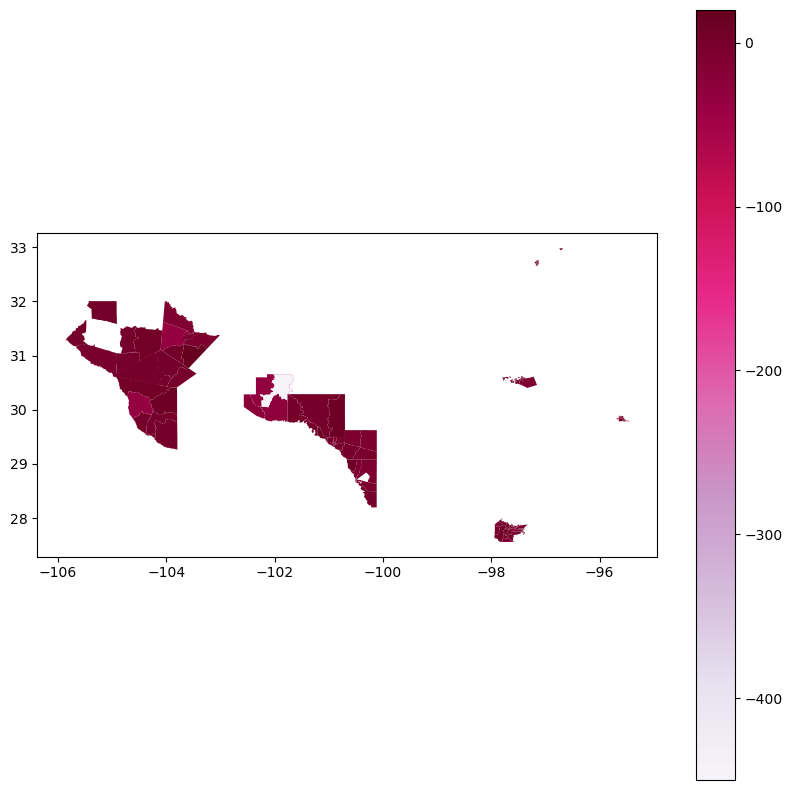

In [ ]:
# Mapping precincts with difference in error rates between Earlier Iterations 
# Replicate once 2024 Precinct Level Results are available
hd_precincts_geo = gpd.GeoDataFrame(hd_precincts, geometry='geography')

hd_precincts_geo['v2_v3_diff'] = (hd_precincts_geo['pct_error_tdp_22'] - hd_precincts_geo['pct_error_dnc_22'])
hd_precincts = hd_precincts_geo.plot(figsize= (10, 10), column = 'v2_v3_diff', k = 10, cmap = 'PuRd', legend = True)


In [136]:
# Load datasets
hd_precincts_geo = gpd.GeoDataFrame(hd_precincts, geometry='geography')
HDmap = gpd.read_file(r"C:\Users\shali\OneDrive\Documents\TDP\HD MODEL\Texas_State_House_Districts_89th_2025_2027.shp")

# Ensure both GeoDataFrames have a CRS
if hd_precincts_geo.crs is None:
    hd_precincts_geo.set_crs(epsg=4326, inplace=True)
if HDmap.crs is None:
    HDmap.set_crs(epsg=4326, inplace=True)

# Reproject both to match CRS
if hd_precincts_geo.crs != HDmap.crs:
    HDmap = HDmap.to_crs(hd_precincts_geo.crs)

# Ensure valid geometries
hd_precincts_geo = hd_precincts_geo[hd_precincts_geo.is_valid]
HDmap = HDmap[HDmap.is_valid]

# Compute column
hd_precincts_geo['v2_v3_diff'] = (
    hd_precincts_geo['pct_error_tdp_22'] - hd_precincts_geo['pct_error_dnc_22']
)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
hd_precincts_geo.plot(
    ax=ax, column='v2_v3_diff', cmap='PuRd',
    scheme='quantiles', k=10, legend=True,
    legend_kwds={'fmt': "{:.2f}"}, edgecolor='none'
)
HDmap.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, alpha=0.5)

plt.title('Texas Precincts with State House Districts Overlay')
plt.show()

ValueError: DataFrame constructor not properly called!

## Control Group Analysis

In [ ]:
QUERY_control_effect_mon4rch = """
CREATE OR REPLACE TABLE `demstxsp.mon4rch_2024.mon4rch_hd_control` AS 
WITH full_df AS (
SELECT 
  person_id, 
  district, 
  voted, 
  positive_id, 
  contact_type_name, 
  result_name,
  control, 
  coordinated_target
FROM `demstxsp.mon4rch_2024.hd_contacts`
), 

control_voted AS (
SELECT 
  district, 
  (CASE WHEN control = 1 AND voted = 1 THEN COUNT(person_id) END) AS control_voted,
FROM full_df
GROUP BY district, control, voted
), 

control_no_vote AS (
SELECT 
  district, 
  (CASE WHEN control = 1 AND voted = 0 THEN COUNT(person_id) END) AS control_no_vote,
FROM full_df
GROUP BY district, control, voted
), 

no_control_voted AS (
SELECT 
  district, 
  (CASE WHEN control = 0 AND voted = 1 THEN COUNT(person_id) END) AS no_control_voted,
FROM full_df
GROUP BY district, control, voted
), 

no_control_no_vote AS (
SELECT 
  district, 
  (CASE WHEN control = 0 AND voted = 0 THEN COUNT(person_id) END) AS no_control_no_vote, 
FROM full_df
GROUP BY district, control, voted
),

hd_control AS (
SELECT 
cv.*, 
cnv.control_no_vote, 
ROUND((cv.control_voted/(cnv.control_no_vote + cv.control_voted))*100, 2)  AS pct_voted_control,
ncv.no_control_voted, 
ncnv.no_control_no_vote,
ROUND((ncv.no_control_voted/(ncnv.no_control_no_vote + ncv.no_control_voted))*100, 2) AS pct_voted_targeted,
FROM control_voted AS cv
LEFT JOIN control_no_vote AS cnv ON cv.district=cnv.district
LEFT JOIN no_control_voted AS ncv ON cv.district=ncv.district
LEFT JOIN no_control_no_vote AS ncnv ON cv.district=ncnv.district
WHERE 
cv.control_voted IS NOT NULL AND 
cnv.control_no_vote IS NOT NULL AND 
ncv.no_control_voted IS NOT NULL AND 
ncnv.no_control_no_vote IS NOT NULL
)

SELECT 
  *, 
  ROUND(pct_voted_targeted - pct_voted_control, 2) AS hd_control_turnout_deficit
FROM hd_control
ORDER BY hd_control_turnout_deficit ASC
"""

control_contacts = pd.read_csv(r"C:\Users\shali\OneDrive\Documents\TDP\Post-Election Analysis\mon4rch support analysis\hd_contacts_control_data.csv")

control_contacts['ethnicity_combined'].value_counts() / control_contacts.shape[0] * 100

W    60.256538
H    25.362676
B     7.696024
A     4.833874
N     0.003847
Name: ethnicity_combined, dtype: float64

## Summary of HD Model Performance

In [ ]:
QUERY_target_hd_history = """
CREATE OR REPLACE TABLE `demstxsp.tdp_partisanship_modeling.target_hd_history` AS 
WITH model_24 AS (
SELECT    
  CAST(LTRIM(hd_24 ,'0')AS INT64) AS HD, 
  ROUND(SUM(tdp_24_support_v4)) AS tdp_24_est_D_votes, 
  ROUND(SUM(dnc_24_support)) AS dnc_24_est_D_votes, 
FROM `demstxsp.tdp_partisanship_modeling.tdp_tx_partisanship_score_v4_incl_prior_hist`
WHERE vote_g_2024 = 1 AND hd_24 IN ('034','052', '054', '070', '074', '094', '096', '112', '118', '121', '138')
GROUP BY hd_24
), 

results_24 AS (
SELECT
  district AS HD,
  D AS act_24_D_votes,
  R AS R_votes_24, 
  L AS L_votes_24, 
  G AS G_votes_24, 
  Other AS W_votes_24, 
FROM `demstxsp.reporting.2024_general_districts_results`
WHERE 
  district_type = 'HD'
  AND CAST(district AS STRING) IN ('34','52', '54', '70', '74', '94', '96', '112', '118', '121', '138')
),

model_22 as (
SELECT    
  CAST(LTRIM(hd_22 ,'0')AS INT64) AS HD, 
  ROUND(SUM(tdp_22_support_v3)) AS tdp_22_est_D_votes, 
  ROUND(SUM(dnc_22_support)) AS dnc_22_est_D_votes, 
FROM `demstxsp.tdp_partisanship_modeling.tdp_tx_partisanship_score_v4_incl_prior_hist`
WHERE vote_g_2022= 1 AND hd_22 IN ('034','052', '054', '070', '074', '094', '096', '112', '118', '121', '138')
GROUP BY hd_22
), 

results_22 AS (
SELECT
  CAST(race_number AS INT64) AS HD,
  SUM(D_votes) AS act_22_D_votes,  
FROM `demstxsp.historical_vtd_2022G.2022_state_house` AS hd22
WHERE race_number IN ('34','52', '54', '70', '74', '94', '96', '112', '118', '121', '138')
GROUP BY race_number
), 

model_20 AS (
SELECT  
  CAST(LTRIM(hd_20 ,'0')AS INT64) AS HD, 
  ROUND(SUM(tdp_20_support_v2)) AS tdp_20_est_D_votes, 
  ROUND(SUM(dnc_20_support_v2)) AS dnc_20_est_D_votes, 
FROM `demstxsp.tdp_partisanship_modeling.tdp_tx_partisanship_score_v4_incl_prior_hist` AS v1
WHERE vote_g_2020 = 1  
  AND hd_20 IN ('034','052', '054', '070', '074', '094', '096', '112', '118', '121', '138')
GROUP BY hd_20
), 

results_20 AS (
SELECT
  CAST(race_number AS INT64) AS HD,
  SUM(D_votes) AS act_20_D_votes,  
FROM `demstxsp.historical_vtd_2022G.2020_state_house` AS hd20
WHERE race_number IN ('34','52', '54', '70', '74', '94', '96', '112', '118', '121', '138')
GROUP BY race_number
)

SELECT DISTINCT
model_24.HD, 
act_24_D_votes,
tdp_24_est_D_votes, 
dnc_24_est_D_votes, 
act_22_D_votes, 
tdp_22_est_D_votes, 
dnc_22_est_D_votes,
act_20_D_votes,  
tdp_20_est_D_votes, 
dnc_20_est_D_votes, 
FROM model_24 
LEFT JOIN results_24 ON model_24.HD = results_24.HD
LEFT JOIN model_22 ON model_24.HD = model_22.HD
LEFT JOIN results_22 ON model_22.HD = results_22.HD
LEFT JOIN model_20 ON model_24.HD = model_20.HD 
LEFT JOIN results_20 ON model_20.HD = results_20.HD
ORDER BY HD ASC
"""

In [ ]:
QUERY_model_comparisons_target_hd_2024 = """
CREATE OR REPLACE TABLE `demstxsp.mon4rch_2024.model_comparisons_target_hd_2024` AS 
WITH actual_dem_votes AS (
SELECT 
HD, 
year, 
act_D_votes
FROM `demstxsp.tdp_partisanship_modeling.target_hd_history`
UNPIVOT (
  act_D_votes FOR year IN (
    act_20_D_votes AS '2020', act_22_D_votes AS '2022', act_24_D_votes AS '2024'))
), 

tdp_est_votes AS (
SELECT 
HD, 
year, 
tdp_est_D_votes
FROM `demstxsp.tdp_partisanship_modeling.target_hd_history`
UNPIVOT (
  tdp_est_D_votes FOR year IN (
    tdp_20_est_D_votes AS '2020', tdp_22_est_D_votes AS '2022', tdp_24_est_D_votes AS '2024'))
), 

dnc_est_votes AS (
SELECT 
HD, 
year, 
dnc_est_D_votes
FROM `demstxsp.tdp_partisanship_modeling.target_hd_history`
UNPIVOT (
  dnc_est_D_votes FOR year IN (
    dnc_20_est_D_votes AS '2020', dnc_22_est_D_votes AS '2022', dnc_24_est_D_votes AS '2024'))
)

SELECT 
act.*, 
tdp_est_D_votes, 
dnc_est_D_votes, 
ABS((act_D_votes-tdp_est_D_votes)/act_D_votes)*100 AS percent_error_tdp, 
ABS((act_D_votes-dnc_est_D_votes)/act_D_votes)*100 AS percent_error_dnc
FROM actual_dem_votes AS act
LEFT JOIN tdp_est_votes AS tdp ON (act.HD = tdp.HD AND act.year = tdp.year)
LEFT JOIN dnc_est_votes AS dnc ON (act.HD = dnc.HD AND act.year = dnc.year)
ORDER BY HD, year ASC
"""

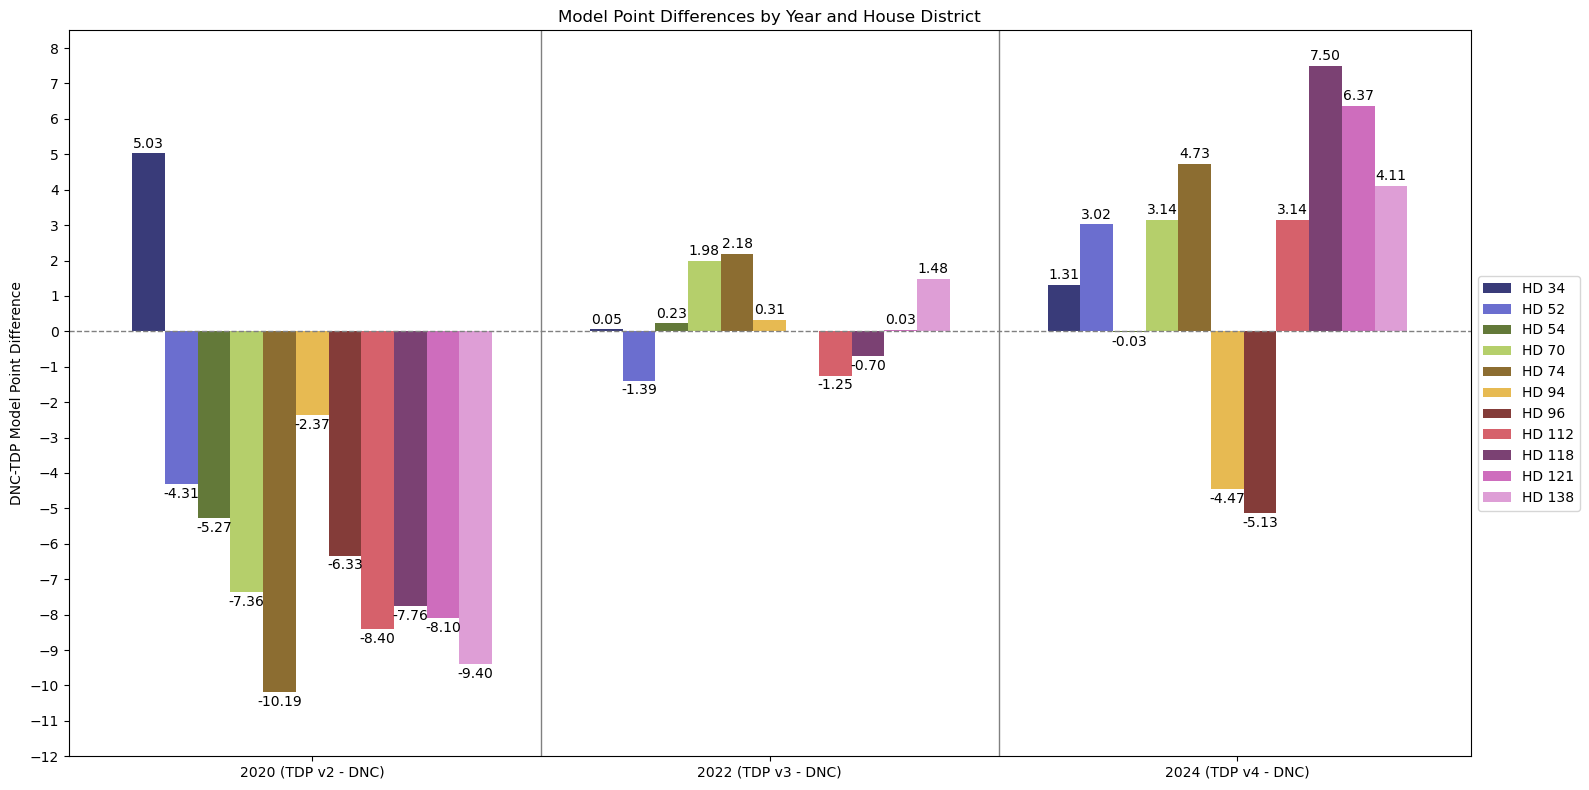

In [ ]:
years = [2020, 2022, 2024]
hd_point_diff = {}
for hd in model_comparisons['HD'].unique():
    measurements = model_comparisons.loc[model_comparisons['HD'] == hd, ['year', 'point_difference']]
    measurements_dict = dict(zip(measurements['year'], measurements['point_difference']))
    hd_point_diff[f'HD {hd}'] = [measurements_dict.get(year, np.nan) for year in years]
hd_point_diff_df = pd.DataFrame(hd_point_diff, index = years)

x = np.arange(len(years))  # the label locations
width = 0.1  # the width of the bars
padding = 0.4  # the padding between groups
multiplier = 0

cmap = cm.get_cmap('tab20b', len(hd_point_diff))
colors = [cmap(i) for i in range(len(hd_point_diff))]
fig, ax = plt.subplots(figsize=(16, 8))

for attribute, measurement in hd_point_diff.items():
    color = colors[multiplier]
    offset = width * multiplier + padding * (np.arange(len(years)) + multiplier // len(hd_point_diff))
    rects = ax.bar(x + offset, measurement, width, label=attribute, color = color)
    ax.bar_label(rects, padding=2, fmt='%.2f')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Model Point Differences by Year and House District')
ax.set_xticks([0.5, 1.9, 3.33])  
ax.set_xticklabels(['2020 (TDP v2 - DNC)', '2022 (TDP v3 - DNC)', '2024 (TDP v4 - DNC)'])


ax.set_ylim(-12, 8.5)
ax.set_yticks(np.arange(-12, 8.5, 1))
ax.set_ylabel('DNC-TDP Model Point Difference')

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(1.2, color='gray', linestyle='-', linewidth=1)
ax.axvline(2.6, color='gray', linestyle='-', linewidth=1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()

The model outperformed the DNC's in 8 of 11 HDs. 
- On a county level the model outperformed the DNC's in 12 of 19 counties.

Overall, it underperformed in State House Districts 54, 94, and 96. 
- Interestingly, despite outperforming the DNC in the HD 74 overall, the model displayed poor class separation in Jeff Davis and Val Verde counties in this district. 

The model underperfomed in HDs and Counties with a largely hispanic population. 